# Imports

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import cv2
import time
import random

from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    MaxPool2D,
    Flatten,
    Dropout,
    Dense,
    ReLU,
)

# GPU Stuff

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-11-25 12:55:53.481393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:55:53.516526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:55:53.516713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# File Paths

In [3]:
# We use the FairFace dataset

train_file = '../databases/fairface/fairface_label_train.csv'
val_file = '../databases/fairface/fairface_label_val.csv'
img_root = '../databases/fairface/'

# Other Parameters

In [4]:
# Columns to drop from the train and validation dataframes
cols_to_drop = ['service_test', 'race']

# Define target labels: 'age', 'gender'
target_label = ['gender', 'age']

# Image size for the conv net
img_size = 64

# Batch size for the conv net
batch_size = 64

# Learning rate of the model
learning_rate = 1e-5

# Optimizer
optimizer = tf.optimizers.Adam(learning_rate)

# Maximum number of epochs
nepochs = 5

# Print training information every display_epoch epochs
display_epoch = 1

# Age labels : for better predictions, we create age groups 
age_labels = ['0-19', '20-29', '30-39', '40-49', '50+']

# Number of age classes used for the loss calculation
n_age_classes = len(age_labels)
ps_n_age_classes = 100

# Data Processing

In [5]:
# This function plots the age distribution as an histogram
def plot_age(df):
    fig = plt.figure(figsize=(10,7))

    ax = fig.add_subplot(111)
    plt.hist(df.age, bins=range(n_age_classes + 1), align='left', rwidth=0.5, density=True)
    ax.set_title('Age Classes', fontdict = {'fontsize': 40})
    ax.set_xlabel('Age classes', fontdict = {'fontsize': 20})
    ax.set_xticks(np.arange(0,n_age_classes,1))

    ax.set_ylabel('Proportion', fontdict = {'fontsize': 20})
    ax.set_xticklabels(age_labels, fontdict = {'fontsize': 15})

    plt.grid()
    plt.show()

In [6]:
# Read dataframes from csv files
raw_train_df = pd.read_csv(train_file)
raw_val_df = pd.read_csv(val_file)

# Number of training and validation examples before filters
ntrain = raw_train_df.shape[0]
nval = raw_val_df.shape[0]

# Apply filters to the dataframes and transform categorical age to numerical
for df in [raw_train_df, raw_val_df]:
    # Drop useless columns
    for col in cols_to_drop:
        df.drop(col, axis=1, inplace=True)
        
    # Add root to the file path
    df.file = df.file.apply(lambda x: img_root + x)
    
    df.gender = df.gender.replace({'Male': 1, 'Female': 0}).astype(int)

    df.age = df.age.replace({'0-2': 0, '3-9': 0, '10-19': 0, 
                             '20-29': 1, '30-39': 2, '40-49': 3, 
                             '50-59': 4, '60-69': 4, 'more than 70': 4}).astype(int)
    
# Number of training and validation examples before filters
ntrain = raw_train_df.shape[0]
nval = raw_val_df.shape[0]

print('Number of training examples: %i.' %ntrain)
print('Number of validation examples: %i.' %nval)
print('--------------------------------------------------')

# Get the number of training and validation batches
n_train_batches = int(np.ceil(raw_train_df.shape[0] / batch_size))
n_val_batches = int(np.ceil(raw_val_df.shape[0] / batch_size))

print('Number of batches in training set: %i.' %n_train_batches)
print('Number of batches in validation set: %i.' %n_val_batches)
print('--------------------------------------------------')

Number of training examples: 86744.
Number of validation examples: 10954.
--------------------------------------------------
Number of batches in training set: 1356.
Number of batches in validation set: 172.
--------------------------------------------------


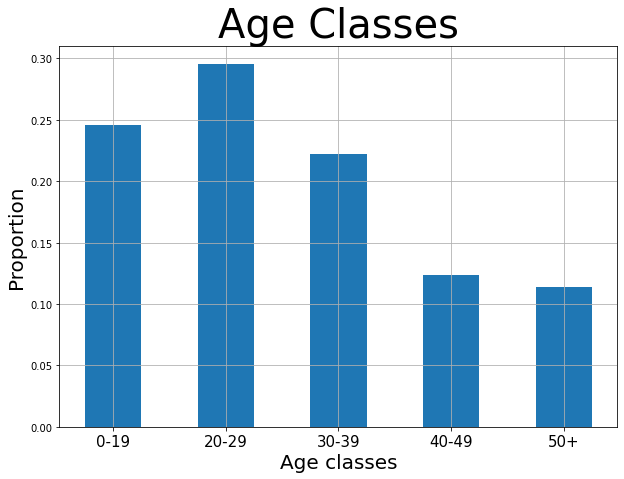

In [7]:
plot_age(raw_train_df)

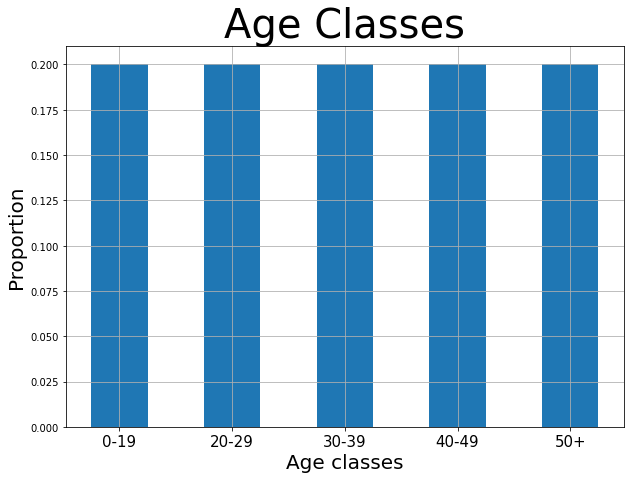

Number of batches in training set: 2000.


In [8]:
# Upsampling
max_size = raw_train_df['age'].value_counts().max()

lst = [raw_train_df]
for class_index, group in raw_train_df.groupby('age'):
    lst.append(group.sample(max_size - len(group), replace=True))
raw_train_df = pd.concat(lst)

plot_age(raw_train_df)

# Get the new number of training batches
n_train_batches = int(np.ceil(raw_train_df.shape[0] / batch_size))

print('Number of batches in training set: %i.' %n_train_batches)

In [9]:
class GenderAgeEstimator(Model):
    def __init__(self):
        super(GenderAgeEstimator, self).__init__()        
        self.conv1 = Conv2D(filters=64, kernel_size=3, name="Conv_1")
        self.maxpool1 = MaxPool2D(strides=2, name="MaxPool_1")
        self.bn1 = BatchNormalization(name="BatchNorm_1")
        self.relu1 = ReLU(name="Relu_1")

        self.conv2 = Conv2D(filters=128, kernel_size=3, name="Conv_2")
        self.maxpool2 = MaxPool2D(strides=2, name="MaxPool_2")
        self.bn2 = BatchNormalization(name="BatchNorm_2")
        self.relu2 = ReLU(name="Relu_2")

        self.conv3 = Conv2D(filters=256, kernel_size=3, name="Conv_3")
        self.maxpool3 = MaxPool2D(strides=2, name="MaxPool_3")
        self.bn3 = BatchNormalization(name="BatchNorm_3")
        self.relu3 = ReLU(name="Relu_3")

        self.conv4 = Conv2D(filters=512, kernel_size=3, name="Conv_4")
        self.maxpool4 = MaxPool2D(strides=2, name="MaxPool_4")
        self.bn4 = BatchNormalization(name="BatchNorm_4")
        self.relu4 = ReLU(name="Relu_4")

        self.flatten = Flatten(name="Flatten")
        self.dropout = Dropout(rate=0.4, name="Dropout")

        self.fc1 = Dense(units=1024, name="Dense")
        self.bn5 = layers.BatchNormalization(name="BatchNorm_5")

        self.out_gender = layers.Dense(units=2, name="Gender")
        self.out_age = layers.Dense(ps_n_age_classes, name="Age")

        self.call(Input(shape=(img_size,img_size,3)))

    # Set forward pass.
    def call(self, x, is_training=False):

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.bn1(x, training=is_training)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.bn2(x, training=is_training)
        x = self.relu2(x)

        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.bn3(x, training=is_training)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.bn4(x, training=is_training)
        x = self.relu4(x)

        x = self.flatten(x)
        x = self.dropout(x, training=is_training)

        x = self.fc1(x)
        x = self.bn5(x, training=is_training)

        # Output for gender
        x_gender = self.out_gender(x)
        if not is_training:
            x_gender = tf.nn.softmax(x_gender)
        
        # Output for age
        x_age = self.out_age(x)
        if not is_training:
            x_age = tf.nn.softmax(x_age)
        
        return (x_gender, x_age)

    def summary(self):
        x = Input(shape=(img_size, img_size, 3), name='Input')
        return Model(inputs=x, outputs=self.call(x), name='GenderAgeEstimator').summary()

# Build model.
model = GenderAgeEstimator()
print(model.summary())

# Load pretrained weights
# model.load_weights('save/model')

Model: "GenderAgeEstimator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 Conv_1 (Conv2D)                (None, 62, 62, 64)   1792        ['Input[0][0]']                  
                                                                                                  
 MaxPool_1 (MaxPooling2D)       (None, 31, 31, 64)   0           ['Conv_1[1][0]']                 
                                                                                                  
 BatchNorm_1 (BatchNormalizatio  (None, 31, 31, 64)  256         ['MaxPool_1[1][0]']              
 n)                                                                              

2022-11-25 12:55:53.986914: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 12:55:53.987442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:55:53.987662: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 12:55:53.987798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:991] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

# Loss

In [10]:
# Function that calculates the predictions mean and rescale it back to the number of age classes
def scaled_mean(y_pred_age):
    mean = tf.reduce_sum(y_pred_age * tf.cast(tf.range(0, ps_n_age_classes, 1), tf.float32), axis=1)
    
    scaled_mean = tf.transpose(mean / ps_n_age_classes * n_age_classes)
    
    return scaled_mean

In [11]:
# Joint loss
def joint_loss(y_pred_gender, y_pred_age, y_true):
    # Extract target labels
    gt_gender = y_true[:, 0]    
    gt_age = y_true[:, 1]
            
    # Loss for gender: cross-entropy
    gt_gender = tf.cast(gt_gender, tf.int64)
    loss_gender = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=gt_gender, logits=y_pred_gender)
    loss_gender = tf.reduce_mean(loss_gender)
    
    # Loss for age: scaled MAE
    gt_age = tf.cast(gt_age, tf.float32)
    
    scaled_age_preds = scaled_mean(y_pred_age)
    
    loss_age = tf.keras.losses.mean_absolute_error(scaled_age_preds, gt_age)
    
    return loss_gender + loss_age

# Optimization

In [12]:
def run_optimization(x, y_true):
    with tf.GradientTape() as g:
        # Forward pass
        y_pred_gender, y_pred_age = model(x, is_training=True)
                
        # Compute joint loss
        loss = joint_loss(y_pred_gender, y_pred_age, y_true)
        
    # Trainable variables.
    trainable_variables = model.trainable_variables

    # Compute gradients
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b
    optimizer.apply_gradients(zip(gradients, trainable_variables))

# Accuracy Metrics

In [13]:
def accuracy_gender(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

def accuracy_age(y_pred, y_true):
    correct_prediction = tf.equal(tf.round(y_pred, tf.float32), tf.cast(y_true, tf.float32))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

# Training

In [14]:
# Function for processing batch images
def process_image(img_path, is_training=False):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.
    img = cv2.resize(img, (img_size, img_size), interpolation = cv2.INTER_NEAREST)
    
    if is_training and random.random() < 0.5:
        # Flip horizontally
        img = cv2.flip(img, 1)
        
        # Motion blur
        size = np.random.randint(1,18)
        kernel_motion_blur = np.zeros((size, size))
        kernel_motion_blur[int((size-1)/2), :] = np.ones(size)
        kernel_motion_blur = kernel_motion_blur / size
        img = cv2.filter2D(img, -1, kernel_motion_blur)
        
    return img

In [ ]:
# Average time taken by an epoch
average_time_epoch = 0

# Create validation batches
val_batches = np.array_split(raw_val_df, n_val_batches)

for epoch in range (1, nepochs + 1):
    # Initialize timings
    start_time_epoch = time.time()
    time_epoch = 0

    # Initialize accuracies
    total_train_acc_gender = 0
    total_train_acc_age = 0
    total_train_loss = 0
    
    total_val_acc_gender = 0
    total_val_acc_age = 0
    total_val_loss = 0
    
    start_time_batch = time.time()
    
    # Create training batches: shuffle and split
    raw_train_df = raw_train_df.sample(frac=1)
    train_batches = np.array_split(raw_train_df, n_train_batches)
    
    # Loop over batches
    for idx, batch in enumerate(train_batches, 1):
        # Get ground truths
        batch_y = batch[['gender', 'age']].values
        
        # Get image paths and process batch images
        batch_x = batch['file'].apply(process_image, args=(True,))
        batch_x = np.stack(batch_x.values).astype('float32')
        
        # Run the optimization to update W and b values.
        run_optimization(batch_x, batch_y)
        
        # Calculate training loss/accuracy for this batch
        train_pred_gender, train_pred_age = model(batch_x)        
        train_loss = joint_loss(train_pred_gender, train_pred_age, batch_y)
        train_acc_gender = accuracy_gender(train_pred_gender, batch_y[:,0])
        train_acc_age = accuracy_age(scaled_mean(train_pred_age), batch_y[:,1])
        
        # Aggregate
        total_train_acc_gender += train_acc_gender
        total_train_acc_age += train_acc_age
        total_train_loss += train_loss
        
    # Calculate mean
    total_train_acc_gender = total_train_acc_gender / n_train_batches
    total_train_acc_age = total_train_acc_age / n_train_batches
    total_train_loss = total_train_loss / n_train_batches
        
    # Calculate validation loss/accuracy
    start_time_batch = time.time()
    
    for idx, batch in enumerate(val_batches, 1):
        # Get ground truths
        batch_y = batch[['gender', 'age']].values
        
        # Get image paths and process batch images
        batch_x = batch['file'].apply(process_image)
        batch_x = np.stack(batch_x.values).astype('float32')
        
        val_pred_gender, val_pred_age = model(batch_x)
        val_loss = joint_loss(val_pred_gender, val_pred_age, batch_y)
        val_acc_gender = accuracy_gender(val_pred_gender, batch_y[:,0])
        val_acc_age = accuracy_age(scaled_mean(val_pred_age), batch_y[:,1])

        # Aggregate
        total_val_acc_gender += val_acc_gender
        total_val_acc_age += val_acc_age
        total_val_loss += val_loss
        
        # Append all ground truths and preds
        if idx == 1:
            all_true_gender = batch_y[:, 0]
            all_true_age = batch_y[:, 1]
            all_file_names = batch['file'].values
            
            all_pred_gender = tf.argmax(val_pred_gender, axis=1).numpy()
            all_pred_age = tf.round(scaled_mean(val_pred_age), tf.float32).numpy()
        
        else:
            all_true_gender = np.append(all_true_gender, batch_y[:, 0])
            all_true_age = np.append(all_true_age, batch_y[:, 1])
            all_file_names = np.append(all_file_names, batch['file'].values)
            
            all_pred_gender = np.append(all_pred_gender, tf.argmax(val_pred_gender, axis=1).numpy())
            all_pred_age = np.append(all_pred_age, tf.round(scaled_mean(val_pred_age), tf.float32).numpy())

    # Calculate mean
    total_val_acc_gender = total_val_acc_gender / n_val_batches
    total_val_acc_age = total_val_acc_age / n_val_batches
    total_val_loss = total_val_loss / n_val_batches
        
    # Keep track of single epoch time
    time_epoch = time.time() - start_time_epoch
           
    # Aggregate time
    average_time_epoch += time_epoch
    
    # Summary
    if epoch % display_epoch == 0:
        print('Epoch %3i |' %epoch, end=' ')
        print('train loss: %0.5f | val loss: %0.5f | time: %0.2f sec.' %(total_train_loss, total_val_loss, time_epoch))
        print('Gender    | train acc : %0.5f | val acc : %0.5f.' %(total_train_acc_gender, total_val_acc_gender))
        print('Age       | train acc : %0.5f | val acc : %0.5f.' %(total_train_acc_age, total_val_acc_age))
        print('=======================================================================')
        
# Calculate and print average time per epoch
average_time_epoch = average_time_epoch / nepochs
print('Average time per epoch: %0.2f sec.' %average_time_epoch)

2022-11-25 12:55:55.319288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8500


In [ ]:
# Save validation set predictions
df = pd.DataFrame()
df['file'] = all_file_names
df['age_true'] = all_true_age
df['age_pred'] = all_pred_age
df['gender_true'] = all_true_gender
df['gender_pred'] = all_pred_gender

df.to_csv('FairFace_validation_set.csv')

# Confusion Matrices

In [ ]:
# Gender confusion matrix
cm_gender = tf.math.confusion_matrix(all_true_gender, all_pred_gender).numpy()

# Age confusion matrice
cm_age = tf.math.confusion_matrix(all_true_age, all_pred_age).numpy()

# Calculate total number of people in each gender/age category
gender_counts = cm_gender.sum(axis=1)
age_counts = cm_age.sum(axis=1)

# Calculate rates
gender_rates = np.zeros(2)
age_rates = np.zeros(n_age_classes)

print('=====================================')
print('============== Summary ==============')
print('=====================================')
for idx, gender in enumerate(['females', 'males']):
    gender_rates[idx] = cm_gender[idx,idx]/gender_counts[idx]*100
    print('Total number of %s is %i.' %(gender, gender_counts[idx]))
    print('Prediction rate of %s is %0.2f%%.' %(gender, gender_rates[idx]))
    print('')
    
print('        =====================        ')
    
for idx, age in enumerate(age_labels):
    age_rates[idx] = cm_age[idx,idx]/age_counts[idx]*100
    print('Total number of %s is %i.' %(age, age_counts[idx]))
    print('Prediction rate of %s is %0.2f%%.' %(age, age_rates[idx]))
    print('')

In [ ]:
# Some dictionnaries for confusion matrices
fontdict_rates_gender = {'fontsize': 15, 'color': 'yellow'}
fontdict_rates_age = {'fontsize': 13, 'color': 'yellow'}

# Plot confusion matrices
# Gender
fig = plt.figure(figsize=(16,6))

ax1 = fig.add_subplot(121)
ax1.set_title('Gender', fontdict = {'fontsize': 40})
ax1 = sns.heatmap(cm_gender, annot=True, fmt="d", linewidths=.5, cmap='coolwarm')

ax1.set_xlabel('Predicted', fontdict = {'fontsize': 20})
ax1.set_xticklabels(['Females', 'Males'], fontdict = {'fontsize': 15})

ax1.set_ylabel('True', fontdict = {'fontsize': 20})
ax1.set_ylim(2,0)
ax1.set_yticklabels(['Females', 'Males'], fontdict = {'fontsize': 15})

for idx, gender in enumerate(['female', 'male']):    
    ax1.text(x=idx+0.35, y=idx+0.65, s='{:.2f}%'.format(gender_rates[idx]), fontdict = fontdict_rates_gender)

# Age
ax2 = fig.add_subplot(122)
ax2.set_title('Age', fontdict = {'fontsize': 40})
ax2 = sns.heatmap(cm_age, annot=True, fmt="d", linewidths=.5, cmap='coolwarm')

ax2.set_xlabel('Predicted', fontdict = {'fontsize': 20})
ax2.set_xticklabels(age_labels, fontdict = {'fontsize': 15})

ax2.set_ylabel('True', fontdict = {'fontsize': 20})
ax2.set_ylim(n_age_classes,0)
ax2.set_yticklabels(age_labels, fontdict = {'fontsize': 15})

for idx, age in enumerate(age_labels):
    ax2.text(x=idx+0.2, y=idx+0.8, s='{:.2f}%'.format(age_rates[idx]), fontdict = fontdict_rates_age)
    
plt.plot();